<a href="https://colab.research.google.com/github/serereuk/torch_ignite_example/blob/master/torch_ignite_example_with_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive mount

오늘의 리빙포인트 

*   구글 드라이브 친구의 동기화 주기는 1분에 300파일 정도인 것 같다.
*   파일 개수가 너무 많으면 구글 드라이브에서 코랩으로 연동이 어렵다 ㅠㅠ 
*   파일 개수가 약 30000개일 경우에 분할압축 후 각 압축을 한 폴더로 각각 만들어서 데이터를 관리하면 된다
*   토치 친구는 mse는 MSELoss면서 mae는 L1Loss로 해두었다.. 역시 통일성이 없는 친구다



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Train Validation set 분리하기

In [3]:
import numpy as np
image_path = np.load('/gdrive/My Drive/dacon_rain/meta.npy')
print(image_path[:4])

['/gdrive/My Drive/dacon_rain/dacon_rain/zip1000.zip/content/train/subset_010479_06.npy'
 '/gdrive/My Drive/dacon_rain/dacon_rain/zip1000.zip/content/train/subset_010480_01.npy'
 '/gdrive/My Drive/dacon_rain/dacon_rain/zip1000.zip/content/train/subset_010493_04.npy'
 '/gdrive/My Drive/dacon_rain/dacon_rain/zip1000.zip/content/train/subset_010486_04.npy']


In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(image_path, test_size=0.05, random_state=419)
print('train set length {} and validation set length {}'.format(len(train), len(test)))

train set length 72527 and validation set length 3818


# 데이터셋 폴더 경로 다시 저장하기

In [0]:
np.save('/gdrive/My Drive/dacon_rain/train_path.npy', train)
np.save('/gdrive/My Drive/dacon_rain/test_path.npy', test)

# 이번 콘텐츠 : 토치 이그나이트 친구 알아보기 

설치는 아래와 같이

토치 이그나이트 친구는 기존에 열심히 쳐야했던 트레인, 평가 부분의 코드들을 간편하게 줄여주는 친구이다.  
하지만 은근 어려운 거 같아서 사실 그냥 치고 말지라는 생각이 드는 패키지!  
최근 다양한 코드에서 발견되는 것을 보아 요새 유행하는 듯? (필자의 사견)

In [2]:
!pip install pytorch-ignite

# import 할 친구들 모음

In [0]:
import torch 
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from ignite.engine import Engine, Events
from ignite.metrics import MeanAbsoluteError, Loss, RunningAverage

# 데이터 로더 부분

In [0]:
def loading(files):
    dataset = np.load(files).astype(np.float32)
    target = dataset[:,:,-1].reshape(1, 40, 40)
    feature = dataset[:, :, :14]
    return feature, target

class Data(Dataset):

    def __init__(self, txts, loader, transform=None):
        self.image_file_path = np.load(txts).tolist()
        self.loader = loader
        self.transform = transform

    def __len__(self):
        return len(self.image_file_path)

    def __getitem__(self, index):
        images = self.image_file_path[index]
        feature, target = self.loader(images)
        if self.transform:
            feature = self.transform(feature)
        
        return feature, target

    

In [55]:
transform_ = Compose([ToTensor()])
trainset = Data('/gdrive/My Drive/dacon_rain/train_path.npy', loading, transform_)
validset = Data('/gdrive/My Drive/dacon_rain/test_path.npy', loading, transform_)
train_loader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(validset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

for i in range(len(trainset)):
    x, y = trainset[i]
    print(i, x.shape, y.shape)
    if i == 3: 
        break

0 torch.Size([14, 40, 40]) (1, 40, 40)
1 torch.Size([14, 40, 40]) (1, 40, 40)
2 torch.Size([14, 40, 40]) (1, 40, 40)
3 torch.Size([14, 40, 40]) (1, 40, 40)


# 단점

속도가 느림 -> 효율적인 코딩 방법을 강구해야함

원인 -> shuffle 하는 부분에서 느림?

그것도 사실 아닌듯 ㅠㅠ

In [56]:
%%time
a, b = next(iter(train_loader))

CPU times: user 310 ms, sys: 147 ms, total: 457 ms
Wall time: 2.31 s


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Unet 부품 만들기

https://github.com/milesial/Pytorch-UNet

위 친구를 많이많이 참고함



In [0]:
class double(nn.Module):
    def __init__(self, inc, outc, midc=None):
        super(double, self).__init__()
        if not midc:
            midc = outc
        self.doub = nn.Sequential(
            nn.Conv2d(inc, midc, kernel_size=3, padding=1),
            nn.BatchNorm2d(midc),
            nn.ReLU(inplace=True),
            nn.Conv2d(midc, outc, kernel_size=3, padding=1),
            nn.BatchNorm2d(outc),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.doub(x)

class down(nn.Module):
    def __init__(self, inc, outc):
        super(down, self).__init__()
        self.maxpool = nn.Sequential(
            nn.MaxPool2d(2),
            double(inc, outc)
        )

    def forward(self, x):
        return self.maxpool(x)

class up(nn.Module):
    def __init__(self, inc, outc, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = double(inc, outc, inc // 2)
        else:
            self.up = nn.ConvTranspose2d(inc, inc//2, kernel_size=2, stride=2)
            self.conv = double(inc, outc)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY //2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class out(nn.Module):
    def __init__(self, inc, outc):
        super(out, self).__init__()
        self.conv = nn.Conv2d(inc, outc, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# Unet 부품 조립하기

In [0]:
class unet(nn.Module):
    def __init__(self, inc, outc, bilinear=True):
        super(unet, self).__init__()
        self.inc = inc
        self.outc = outc
        self.bilinear =bilinear
        self.start = double(inc, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = down(256, 512 // factor)
        self.up1 = up(512, 256 // factor, self.bilinear)
        self.up2 = up(256, 128 // factor, self.bilinear)
        self.up3 = up(128, 64, self.bilinear)
        self.out = out(64, outc)

    def forward(self, x):
        x1 = self.start(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.out(x)
        return x
    

In [0]:
model = unet(14, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mae_loss = nn.L1Loss(reduction='sum')

In [0]:
def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch 
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    loss =  mae_loss(pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [0]:
def evaluate_function(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x = x.to(device)
        pred = model(x)
        return pred, y

In [0]:
trainer = Engine(process_function)
evaluator = Engine(evaluate_function)
training_history = {'loss': []}
validation_history = {'loss': []}
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')
MeanAbsoluteError(output_transform=lambda x: [x[0], x[1]]).attach(evaluator, 'loss')

In [64]:
@trainer.on(Events.EPOCH_COMPLETED)
def print_trainer_logs(engine):
    avg_loss = engine.state.metrics['loss']
    print('Trainer Results - EPOCH {} - Avg Loss : {:2f}'.format(engine.state.epcoh, avg_loss))

def print_logs(engine, dataloader, mode, history_dict):
    evaluator.run(dataloader, max_epoch=1)
    metrics = evaluator.state.metrics
    avg_loss = metrics['loss']
    print(
        mode + 'Results - Epoch {} - Avg mae : {:f}'.format(engine.state.epoch, avg_loss)
    )
    for key in evaluator.state.metrics.keys(): history_dict[key].append(evaluator.state.metrics[key])

trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, train_loader, 'Training', training_history)
trainer.add_event_handler(Events.EPOCH_COMPLETED, print_logs, valid_loader, 'Validation', validation_history)


In [0]:
e = trainer.run(train_loader, max_epochs=2)

In [51]:
training_history, validation_history

({'loss': []}, {'loss': []})

# Dice Loss implementation

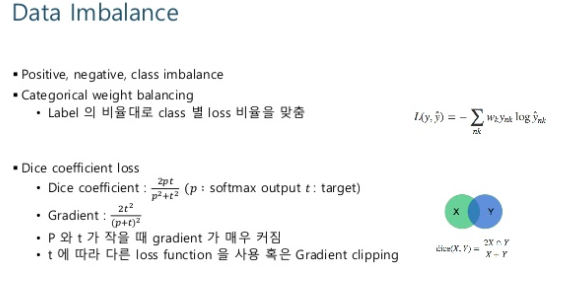

In [0]:
import torch
from torch.autograd import Function


class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)